# Introduction
In the test we performed with just CNN1d, we found that local effects such as distortion are reproducible using these cnns. However, more temporally distributed effects are not captured accurately. In this experiment we try to remedy that using an approach based on [this github repo](https://github.com/GuitarML/GuitarLSTM), which in turn is based on [this paper](https://www.mdpi.com/2076-3417/10/3/766/htm) by the people behind Neural DSP. The introduction of an LSTM layer here is aimed at introducing more possibility for temporally distributed effects. The authors of the paper call this a [WaveNet](https://arxiv.org/pdf/1609.03499.pdf) style model. 

In [3]:
from support_functions import *
from pedalboard import Chorus, Reverb, Distortion

%matplotlib inline

<AxesSubplot:>

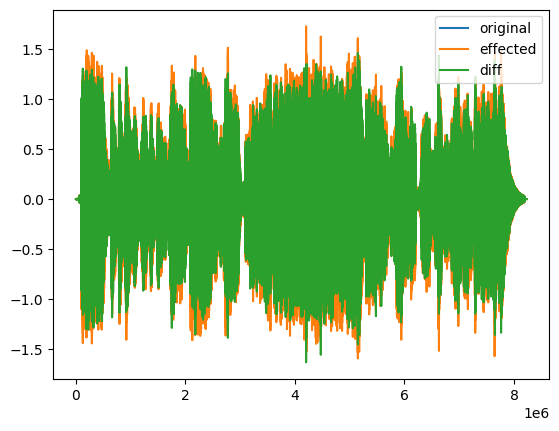

In [13]:
dist = read_proces_dump('data/clean_guitar_large_sample.wav', 
                 'data/distortion_guitar_large_sample.wav', 
                 [Distortion(), Reverb(room_size=0.25)])
wav_player('data/distortion_guitar_large_sample.wav')
dist.plot()

Build a wavenet style model:
- Using [causal convolutions](https://subscription.packtpub.com/book/data/9781789136364/4/ch04lvl1sec59/dilated-and-causal-convolution)
- Not using any pooling layers

TODO:
- Perform a lot more research on how this works exactly. For now, just go for the LSTM. 

In [14]:
from keras import Sequential, Model
import keras.layers as layers
import tensorflow as tf

chunk_size = 4096    
wav_length = len(dist)
max_multiple = wav_length - (wav_length % chunk_size)
original_chunked = dist['original'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))   
effected_chunked = dist['effected'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))

kernel_size=3  # <---- started with 3, from a https://github.com/GuitarML/GuitarLSTM/blob/main/train.py tried 12, but this lead to massive
               #       overfitting

# Have not really played around with the layers, this 
# architecture is something roughly copied from a paper about
# selfsupervised learning 
model = Sequential(
    [
        layers.Conv1D(32, kernel_size=kernel_size, input_shape=(chunk_size,1), padding='causal', activation='relu', dilation_rate=1),
        layers.Conv1D(32, kernel_size=kernel_size, padding='causal', activation='relu', dilation_rate=2),
        layers.Conv1D(32, kernel_size=kernel_size, padding='causal', activation='relu', dilation_rate=4),

        layers.Conv1D(1, kernel_size=kernel_size, padding='causal', activation='linear') # <---- needs to be linear and not relu to be able to generate negative numbers
    ]
)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)   # <---- Needs to be rather low to actually learn anything
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 4096, 32)          128       
                                                                 
 conv1d_9 (Conv1D)           (None, 4096, 32)          3104      
                                                                 
 conv1d_10 (Conv1D)          (None, 4096, 32)          3104      
                                                                 
 conv1d_11 (Conv1D)          (None, 4096, 1)           97        
                                                                 
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
import numpy as np

untrained_prediction = model.predict(np.resize(original_chunked[:,2], (1, chunk_size, 1)))
untrained_prediction.shape

1/1 [==============================] - 0s 166ms/step


(1, 4096, 1)

Epoch 1/100
402/402 [==============================] - 2s 4ms/step - loss: 0.0760 - val_loss: 0.0295
Epoch 2/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.0198
Epoch 3/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0183 - val_loss: 0.0175
Epoch 4/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0168 - val_loss: 0.0168
Epoch 5/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 6/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 7/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0160
Epoch 8/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 9/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 10/100
402/402 [==============================] - 1s 3ms/step - loss: 0.0156 - val_lo

<AxesSubplot:>

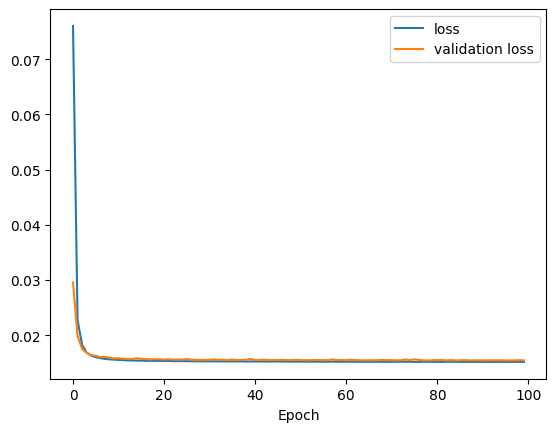

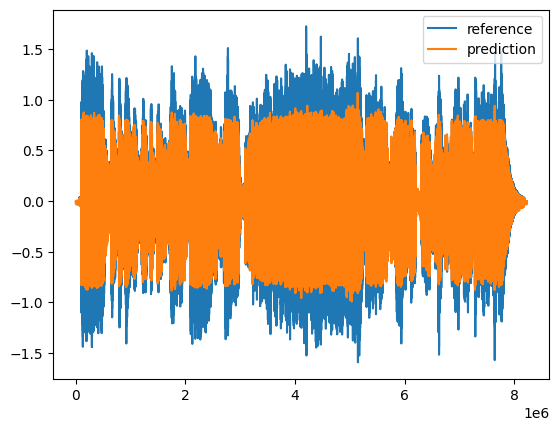

In [15]:
from sklearn.model_selection import train_test_split

original_train, original_test, effected_train, effected_test = train_test_split(original_chunked, effected_chunked, test_size=0.2)
history = model.fit(original_train, effected_train, epochs=100, batch_size=4, validation_data=(original_test, effected_test))

plot_loss(history)

trained_entire_clip = model.predict(np.resize(original_chunked, (original_chunked.size // chunk_size, chunk_size, 1)))
dump_numpy_audio(resize_to_mono(trained_entire_clip),
                 reference_wav='data/clean_guitar.wav',
                 output_wav='data/trained_distortion_guitar.wav')
wav_player('data/trained_distortion_guitar.wav')

trained_flat = trained_entire_clip.flatten()
pd.DataFrame({'reference': dist['effected'][0:len(trained_flat)], 
              'prediction': trained_flat}).plot()